# Case study: multiple genes min change attack on a SVM classifier

We built a SVM classifier stable enough such that the classic one gene "min change" attack doesn't work.
In this notebook we show how to use the <code>advGridMinChange</code> function to generate a *min change attack* with a combination of a few number of genes.

Details:
- the attack is made on the **Dendritic Cells** (DC) cluster
- the attack can not use the marker genes defined earlier as these genes are used by humans for manual classification of cell clusters. The goal of the attack is to deceive the classifier without raising suspicions among the humans.

Steps:
- the <code>advMaxChange</code> function gives us a first list of potential interesting genes
- Seurat <code>findMarkers</code> function gives us a second list of potential interesting genes
- the <code>advRandWalkMinChange</code> function makes a random walk based parameter search on the two previously generated gene lists and report the results.
- the <code>advGridMinChange</code> function makes a complete grid based parameter search on a few genes.

# Loads

In [20]:
# Libraries
library(Seurat)
library(stringr)
library(e1071)
library(IRdisplay)
# Notebook plot sizes
options(repr.plot.width=15, repr.plot.height=10)

# Load adverSCarial library
source("R/adverscarial.r")

In [2]:
options(repr.plot.width=12, repr.plot.height=8)

In [3]:
# Load scRAN-seq pbmc dataset as a Seurat object
pbmc = readRDS("data/datasets/pbmc.rds")

# SVM classifier: classifier in svmfit object
load("classifiers/svm_scrnaseq")

In [4]:
rna_matrix = t(as.matrix(pbmc@assays$RNA@counts))
clusters_id = pbmc@meta.data$manual_annotation

# The genes we can not use for the attack
The [Seurat documentation](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html) provides markers allowing to assign a cell type to each cluster:

| Cluster ID  | Markers  | Cell Type  |
|---|---|---|
| 0  | IL7R, CCR7  | Naive CD4+ T  |
| 1  | CD14, LYZ  | CD14+ Mono  |
| 2  | IL7R, S100A4  | Memory CD4+  |
| 3  | MS4A1  | B  |
| 4  | CD8A  | CD8+ T  |
| 5  | FCGR3A, MS4A7  | FCGR3A+ Mono  |
| 6  | GNLY, NKG7  | NK  |
| 7  | FCER1A, CST3  | DC  |
| 8  | PPBP  | Platelet  |

These are the genes we don't modify, such that when humans plot a DotPlot they don't see the changes due to the adversarial attack. 

In [5]:
# Known markers for each cell type
markers_4humans = c("IL7R", "CCR7", "CD14", "LYZ", "S100A4", "MS4A1", "CD8A", "FCGR3A", "MS4A7",
              "GNLY", "NKG7", "FCER1A", "CST3", "PPBP")

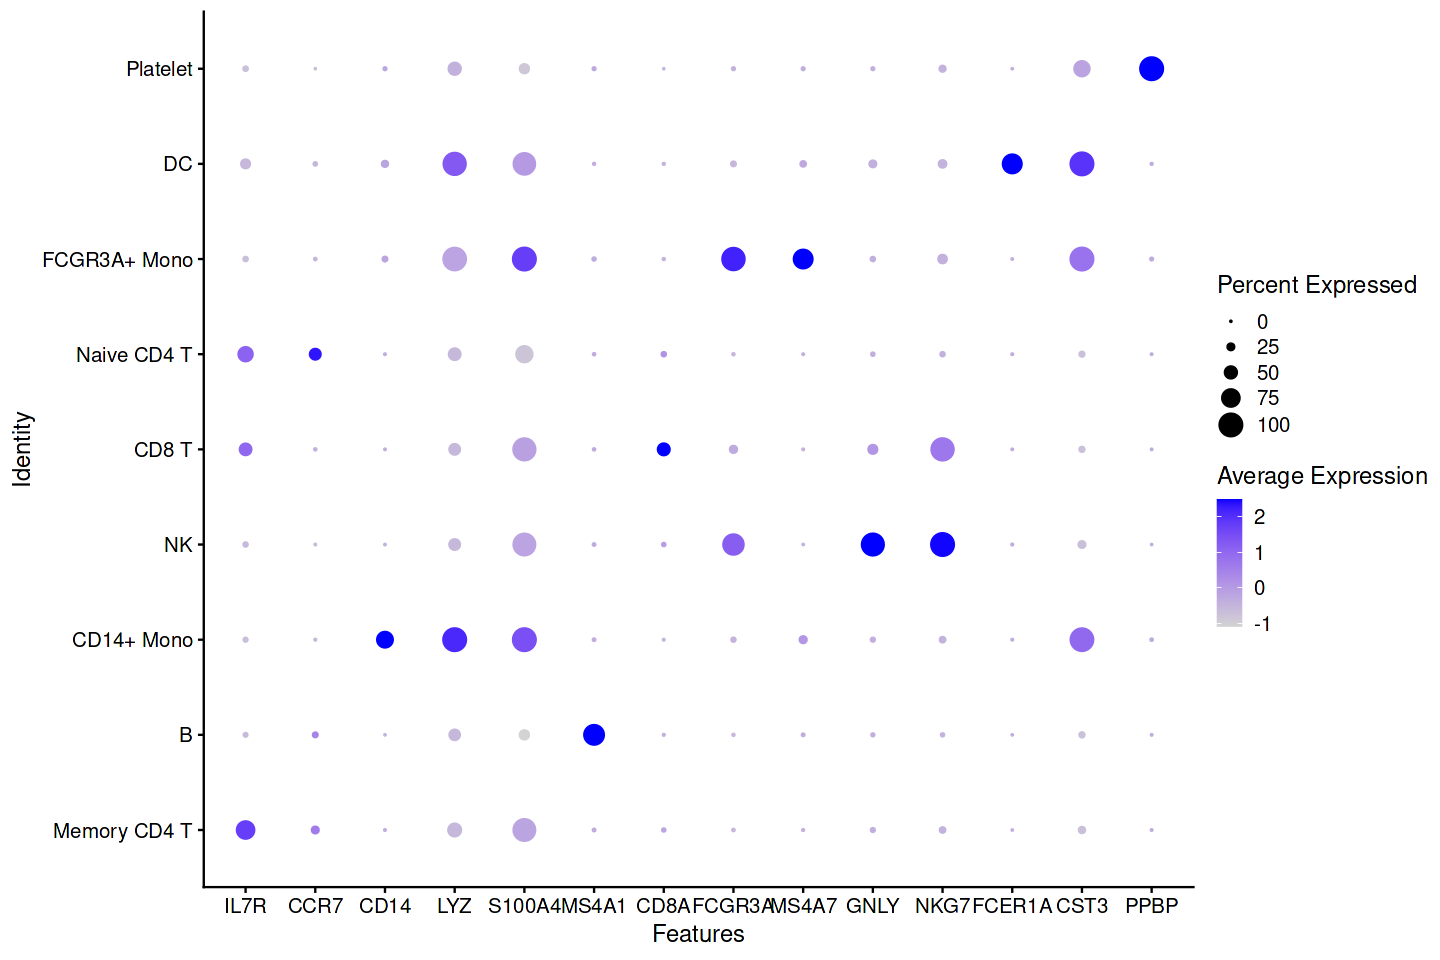

In [6]:
DotPlot(pbmc, features = markers_4humans)

# Get the neighbour of DC
Usually the easiest way is to transform the cluster into its closest neighbour. We can see on the UMAP below that the closest cluster of the DC is the **CD14+ Mono**. We will study the genes able to transform the DC cluster into a CD14+ Mono cluster.

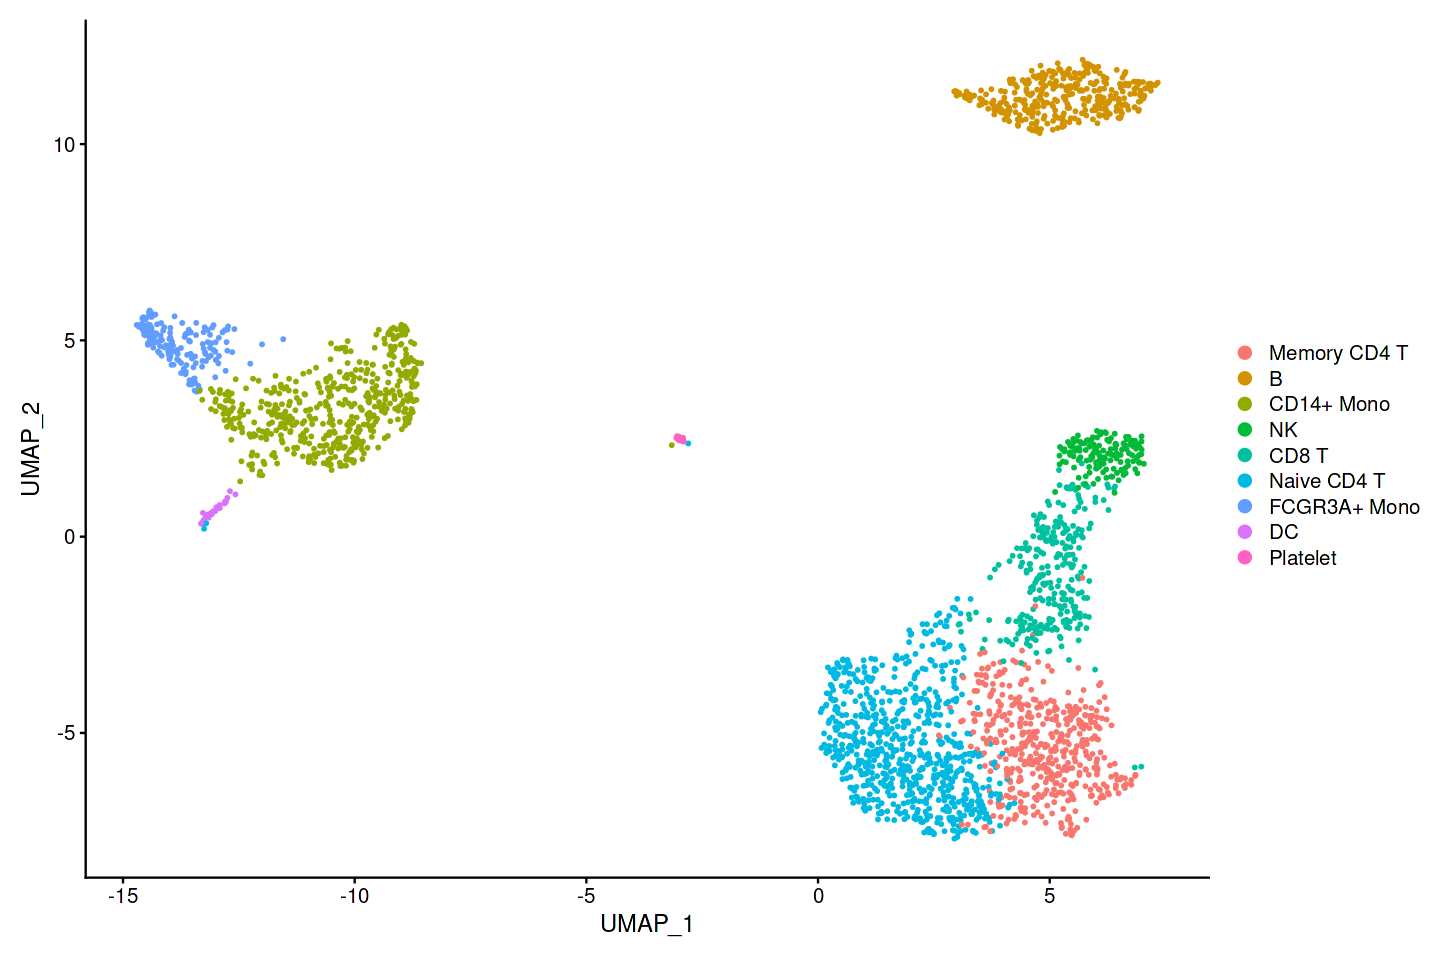

In [7]:
DimPlot(pbmc)

# Get the markers provided by Seurat
We use the <code>findMarkers</code> Seurat function to find over and under expressed genes between *CD14+ Mono* and *DC*

In [8]:
diff_genes = FindMarkers(pbmc, ident.1 = "DC", ident.2="Memory CD4 T")

In [9]:
head(diff_genes)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
FCER1A   2.164299e-86 3.961568   0.812 0.002 2.968120e-82
HLA-DQA2 3.857295e-79 3.082486   0.844 0.011 5.289894e-75
HLA-DQA1 3.445725e-76 4.432664   0.969 0.030 4.725468e-72
CLEC10A  4.305694e-72 2.579915   0.688 0.002 5.904828e-68
IFI30    3.692405e-66 1.921565   0.688 0.006 5.063764e-62
CD33     1.227478e-61 1.690531   0.625 0.004 1.683363e-57

We only retain markers with an average log2 fold change greater than 2 or less than -2.

In [10]:
head(diff_genes[diff_genes$avg_log2FC>2,])

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
FCER1A   2.164299e-86 3.961568   0.812 0.002 2.968120e-82
HLA-DQA2 3.857295e-79 3.082486   0.844 0.011 5.289894e-75
HLA-DQA1 3.445725e-76 4.432664   0.969 0.030 4.725468e-72
CLEC10A  4.305694e-72 2.579915   0.688 0.002 5.904828e-68
CPVL     1.917655e-60 2.342745   0.812 0.025 2.629872e-56
HLA-DMA  7.020205e-60 3.087092   0.969 0.057 9.627509e-56

In [11]:
head(diff_genes[diff_genes$avg_log2FC< -2,])

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
CD3D    6.576039e-18 -3.312792  0.156 0.922 9.018380e-14
LTB     8.943595e-18 -3.184531  0.500 0.981 1.226525e-13
IL32    1.691942e-17 -3.194142  0.281 0.949 2.320329e-13
CD3E    7.628353e-14 -2.635973  0.156 0.833 1.046152e-09
PTPRCAP 8.180672e-12 -2.032692  0.281 0.856 1.121897e-07
IL7R    1.476829e-09 -2.235303  0.344 0.748 2.025324e-05

In [12]:
markers_by_seurat = rownames(diff_genes[abs(diff_genes$avg_log2FC) > 2,])
markers_by_seurat

[1] "FCER1A"   "HLA-DQA2" "HLA-DQA1" "CLEC10A"  "CPVL"     "HLA-DMA" 
 [7] "LGALS2"   "HLA-DRB5" "ALDH2"    "HLA-DMB"  "SPI1"     "LY86"    
[13] "FCER1G"   "GRN"      "TYROBP"   "HLA-DRB1" "HLA-DQB1" "MS4A6A"  
[19] "CST3"     "CFP"      "HLA-DPA1" "IFITM3"   "HLA-DPB1" "HLA-DRA" 
[25] "AIF1"     "AP1S2"    "LST1"     "TYMP"     "GSTP1"    "GPX1"    
[31] "CD74"     "LYZ"      "CD3D"     "LTB"      "IL32"     "LGALS1"  
[37] "CD3E"     "PTPRCAP"  "C1orf162" "IL7R"     "S100A9"   "LCK"     
[43] "CD7"      "GZMB"

# Important features for **DC** for the SVM classifier
We utilize the <code>advMaxChange</code> adverSCarial function to identify the maximum number of genes that can be modified without altering the dendritic cell (DC) classification. We then take the complement to identify the genes that are most likely to impact the classification of the cluster.

In [13]:
SVMClassifier = function(expr, clusters, target, seed=20){
    set.seed(seed)
    colnames(expr) = str_replace_all(colnames(expr),"-","_")
    colnames(expr) = str_replace(colnames(expr),"^","g_")

    final_predictions <- predict(svmfit, expr[clusters==target,])
    ratio = as.numeric(sort(table(final_predictions), decreasing = T)[1]) / sum(as.numeric(sort(table(final_predictions), decreasing = T)))
    predicted_class = names(sort(table(final_predictions), decreasing = T)[1])
    if ( ratio < 0.3){
        predicted_class = "NA"
    }
    c(predicted_class, ratio)
}

In [14]:
max_change_results_perc1 = advMaxChange(rna_matrix, clusters_id, "DC", SVMClassifier,adv_method="perc1",verbose=T)

genes size: 13714

before predictWithNewValue 1

6857

create mask

modify data

Classifier

DC

0.90625

same cell_type 1

before predictWithNewValue 2

6857

create mask

modify data

Classifier

NA

0.28125

NOT same cell_type 2

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 6857

before predictWithNewValue 1

3428

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

3429

create mask

modify data

Classifier

NA

0.25

NOT same cell_type 2

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 3429

before predictWithNewValue 1

1714

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithN

genes size: 7

before predictWithNewValue 1

3

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

4

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

genes size: 4

before predictWithNewValue 1

2

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

2

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

genes size: 2

before predictWithNewValue 1

1

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Class

In [15]:
max_change_results_perc99 = advMaxChange(rna_matrix, clusters_id, "DC", SVMClassifier,adv_method="perc99",verbose=T)

genes size: 13714

before predictWithNewValue 1

6857

create mask

modify data

Classifier

CD14+ Mono

1

NOT same cell_type 1

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 6857

before predictWithNewValue 1

3428

create mask

modify data

Classifier

DC

1

same cell_type 1

before predictWithNewValue 2

3429

create mask

modify data

Classifier

NA

0.25

NOT same cell_type 2

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 3429

before predictWithNewValue 1

1714

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

1715

create mask

modify data

Classifier

DC

0.75

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

Warning message in 

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 107

before predictWithNewValue 1

53

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

54

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

genes size: 54

before predictWithNewValue 1

27

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

27

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists s

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

2

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

7

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

27

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

54

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

3429

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

mo

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 7

before predictWithNewValue 1

3

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

4

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

genes size: 4

before predictWithNewValue 1

2

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

2

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier



Classifier

NO: split and retry

genes size: 6

before predictWithNewValue 1

3

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

Warning message in split.default(unlist(genes), 1:2):
“data length is not a multiple of split variable”
genes size: 3

before predictWithNewValue 1

1

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

YES: merge results

before predictWithNewValue 2

2

create mask

modify data

Classifier

DC

1

same cell_type 2

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

genes size: 2

before predictWithNewValue 1

1

create mask

modify data

Classifier

DC

1

same cell_type 1

check if concat lists still gives target

create mask

modify data

Classifier

NO: split and retry

before predictWithNewValue 2

1

In [16]:
save.image("session/006_20230124_full1")

Interestingly both results gives the same genes

In [17]:
length(max_change_results_perc99)

[1] 13704

In [18]:
length(max_change_results_perc1)

[1] 13711

In [19]:
all(max_change_results_perc99 == max_change_results_perc1)

Warning message in max_change_results_perc99 == max_change_results_perc1:
“longer object length is not a multiple of shorter object length”


[1] FALSE

The complement returns 10 genes.

In [20]:
markers_complement_max_change = colnames(rna_matrix)[!colnames(rna_matrix) %in% max_change_results_perc1]
markers_complement_max_change

[1] "HLA-DRA" "LYZ"     "RPS2"

# Creation of the gene list to test

We have 3 genes list:
- <code>markers_4humans</code> the list of genes we can't use
- <code>markers_by_seurat</code> from the *Seurat* <code>findMarkers</code> analysis
- <code>markers_complement_max_change</code> from the <code>advMaxChange</code> analysis

We build the gene list to study from these 3 previous list.

In [21]:
genes_4walk = c(markers_by_seurat, markers_complement_max_change)
genes_4walk = genes_4walk[!genes_4walk %in% markers_4humans]
genes_4walk = unique(genes_4walk)
genes_4walk

[1] "HLA-DQA2" "HLA-DQA1" "CLEC10A"  "CPVL"     "HLA-DMA"  "LGALS2"  
 [7] "HLA-DRB5" "ALDH2"    "HLA-DMB"  "SPI1"     "LY86"     "FCER1G"  
[13] "GRN"      "TYROBP"   "HLA-DRB1" "HLA-DQB1" "MS4A6A"   "CFP"     
[19] "HLA-DPA1" "IFITM3"   "HLA-DPB1" "HLA-DRA"  "AIF1"     "AP1S2"   
[25] "LST1"     "TYMP"     "GSTP1"    "GPX1"     "CD74"     "CD3D"    
[31] "LTB"      "IL32"     "LGALS1"   "CD3E"     "PTPRCAP"  "C1orf162"
[37] "S100A9"   "LCK"      "CD7"      "GZMB"     "RPS2"

In [22]:
length(genes_4walk)

[1] 41

# The <code>advRandWalkMinChange</code> function

The <code>genes_4walk</code> contains genes highly susceptible to make our SVM classifier results change. We use it in the <code>advRandWalkMinChange</code> function to find a *min change* adversarial attack on the pbmc dataset.

The <code>advRandWalkMinChange</code> function employs a two-step approach to tend to the best parameters. First, it selects random modifications on a subset of genes and evaluates the effectiveness of these changes to change the classification. Once a valid combination is found, the function runs a random walk on the modifications and genes to further refine the solution and minimize the number of genes that need to be modified.

The function requires a list of modifications to test. In this case, we test two modifications:
- switch off the gene using the *perc1* modification
- switch on the gene using the *perc99* modification

In [23]:
modifications = list()
modifications[[1]] = list("perc1")
modifications[[2]] = list("perc99")

In [6]:
rand_walk_min_change_attacks = advRandWalkMinChange(rna_matrix, clusters_id, "DC", SVMClassifier, genes=genes_4walk, modifications=modifications, walk_length=100, seed=20)

Running first batch to determine walk seed: 1 on 100

Running first batch to determine walk seed: 2 on 100

Walk step 1 on 100

Better attack with only 39 genes modified



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[17] "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
[33] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
[41] "perc1"

[1] "CD14+ Mono" "0.4375"     "39"         "TRUE"       "2"         
 [6] "perc1"      "perc1"      "perc99"     "perc1"      "perc1"     
[11] "NA"         "perc1"      "perc1"      "perc1"      "perc1"     
[16] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[21] "perc1"      "perc99"     "perc1"      "perc1"      "perc1"     
[26] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[31] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[36] "perc1"      "NA"         "perc1"      "perc1"      "perc1"     
[41] "perc1"      "perc1"      "perc1"      "perc99"     "perc1"     
[46] "perc1"

Walk step 2 on 100

Better attack with only 38 genes modified



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[17] "perc99" "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "38"         "TRUE"       "3"         
 [6] "perc1"      "perc1"      "perc99"     "perc1"      "perc1"     
[11] "NA"         "NA"         "perc1"      "perc1"      "perc1"     
[16] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[21] "perc1"      "perc99"     "perc99"     "perc1"      "perc1"     
[26] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[31] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[36] "perc1"      "perc1"      "NA"         "perc1"      "perc1"     
[41] "perc1"      "perc1"      "perc1"      "perc99"     "perc99"    
[46] "perc1"

Walk step 3 on 100

Better attack with only 34 genes modified



[1] "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc1" 
[17] "perc99" "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "34"         "TRUE"       "4"         
 [6] "perc1"      "perc1"      "NA"         "NA"         "perc1"     
[11] "NA"         "NA"         "perc1"      "perc1"      "perc1"     
[16] "perc1"      "NA"         "perc1"      "NA"         "perc1"     
[21] "perc1"      "perc99"     "perc99"     "perc1"      "perc1"     
[26] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[31] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[36] "perc1"      "perc1"      "NA"         "perc1"      "perc1"     
[41] "perc1"      "perc1"      "perc1"      "perc99"     "perc99"    
[46] "perc1"

Walk step 4 on 100

Better attack with only 32 genes modified



[1] "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"    
[17] "perc99" "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "32"         "TRUE"       "5"         
 [6] "perc1"      "perc1"      "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "perc1"      "perc1"      "perc1"     
[16] "perc1"      "NA"         "perc1"      "NA"         "perc1"     
[21] "NA"         "perc99"     "perc99"     "perc1"      "perc1"     
[26] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[31] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[36] "perc1"      "perc1"      "NA"         "perc1"      "perc1"     
[41] "perc1"      "perc1"      "perc1"      "perc99"     "perc99"    
[46] "perc1"

Walk step 5 on 100

Better attack with only 30 genes modified



[1] "perc99" "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"    
[17] "perc99" "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "30"         "TRUE"       "6"         
 [6] "perc99"     "perc1"      "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[16] "perc1"      "NA"         "perc1"      "NA"         "perc1"     
[21] "NA"         "perc99"     "NA"         "perc1"      "perc1"     
[26] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[31] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[36] "perc1"      "perc1"      "NA"         "perc1"      "perc1"     
[41] "perc1"      "perc1"      "perc1"      "perc99"     "perc99"    
[46] "perc1"

Walk step 6 on 100



[1] "DC"      "0.53125" "29"      "FALSE"   "7"       "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "NA"      "NA"      "NA"      "perc1"  
[15] "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"      "NA"     
[22] "perc99"  "NA"      "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
[29] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
[36] "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"   "perc1"  
[43] "perc1"   "perc99"  "perc99"  "perc1"

Walk step 7 on 100



[1] "DC"     "0.875"  "29"     "FALSE"  "8"      "perc99" "perc1"  "NA"    
 [9] "NA"     "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc1" 
[17] "NA"     "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"     "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "NA"     "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"    
[41] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"

Walk step 8 on 100



[1] "DC"     "0.875"  "29"     "FALSE"  "9"      "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc1" 
[17] "NA"     "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"     "perc1" 
[25] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
[41] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"

Walk step 9 on 100



[1] "DC"     "1"      "26"     "FALSE"  "10"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc1" 
[17] "NA"     "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"     "perc99"
[25] "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
[33] "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc1" 
[41] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"

Walk step 10 on 100

Better attack with only 27 genes modified



[1] "perc99" "perc99" "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "perc99" "NA"     "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[25] "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
[33] "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "27"         "TRUE"       "11"        
 [6] "perc99"     "perc99"     "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[16] "perc1"      "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "perc99"     "NA"         "NA"         "perc1"     
[26] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[31] "NA"         "perc1"      "perc1"      "perc1"      "perc1"     
[36] "perc1"      "perc1"      "perc99"     "perc1"      "perc1"     
[41] "perc1"      "perc1"      "NA"         "perc99"     "perc99"    
[46] "perc1"

Walk step 11 on 100

Better attack with only 26 genes modified



[1] "perc99" "perc99" "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
[25] "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.4375"     "26"         "TRUE"       "12"        
 [6] "perc99"     "perc99"     "perc1"      "NA"         "perc99"    
[11] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[16] "perc1"      "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "perc1"     
[26] "perc1"      "perc1"      "perc1"      "NA"         "perc1"     
[31] "NA"         "perc1"      "perc1"      "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "perc1"     
[41] "perc1"      "perc1"      "NA"         "perc99"     "perc99"    
[46] "perc1"

Walk step 12 on 100

Better attack with only 24 genes modified



[1] "perc99" "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc1"  "NA"    
[25] "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99" "perc99"
[41] "perc1"

[1] "CD14+ Mono" "0.4375"     "24"         "TRUE"       "13"        
 [6] "perc99"     "perc99"     "perc1"      "perc1"      "perc99"    
[11] "perc99"     "NA"         "NA"         "perc1"      "perc1"     
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc1"      "NA"         "perc1"     
[31] "NA"         "NA"         "perc1"      "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "perc1"      "perc1"      "NA"         "perc99"     "perc99"    
[46] "perc1"

Walk step 13 on 100

Better attack with only 23 genes modified



[1] "perc99" "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc1"  "NA"    
[25] "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99" "perc1" 
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "23"         "TRUE"       "14"        
 [6] "perc99"     "perc99"     "perc1"      "perc1"      "perc99"    
[11] "perc99"     "NA"         "NA"         "perc1"      "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc1"      "NA"         "perc1"     
[31] "NA"         "NA"         "perc1"      "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "perc1"      "perc1"      "NA"         "perc99"     "perc1"     
[46] "perc1"

Walk step 14 on 100

Better attack with only 22 genes modified



[1] "perc99" "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc1"  "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99" "perc1" 
[41] "perc1"

[1] "CD14+ Mono" "0.4375"     "22"         "TRUE"       "15"        
 [6] "perc99"     "perc99"     "perc1"      "perc1"      "perc99"    
[11] "perc99"     "NA"         "perc99"     "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc1"      "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "perc1"      "perc1"      "NA"         "perc99"     "perc1"     
[46] "perc1"

Walk step 15 on 100

Better attack with only 21 genes modified



[1] "perc99" "perc99" "perc99" "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc99" "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99" "perc1" 
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "21"         "TRUE"       "16"        
 [6] "perc99"     "perc99"     "perc99"     "perc1"      "perc99"    
[11] "NA"         "NA"         "perc1"      "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc99"     "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "perc1"      "perc1"      "NA"         "perc99"     "perc1"     
[46] "perc1"

Walk step 16 on 100



[1] "DC"     "1"      "18"     "FALSE"  "17"     "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "perc99" "NA"     "perc1"  "NA"     "NA"    
[33] "NA"     "NA"     "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "NA"    
[41] "NA"     "perc1"  "NA"     "perc99" "NA"     "perc1"

Walk step 17 on 100

Better attack with only 19 genes modified



[1] "perc99" "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc99" "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "NA"     "perc1" 
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "19"         "TRUE"       "18"        
 [6] "perc99"     "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "perc1"      "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc99"     "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "perc1"      "perc1"      "NA"         "NA"         "perc1"     
[46] "perc1"

Walk step 18 on 100

Better attack with only 18 genes modified



[1] "perc99" "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc99" "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"     "perc1" 
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "18"         "TRUE"       "19"        
 [6] "perc99"     "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "perc99"     "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc99"     "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "NA"         "perc1"      "NA"         "NA"         "perc1"     
[46] "perc1"

Walk step 19 on 100

Better attack with only 17 genes modified



[1] "perc99" "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "perc99" "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"    
[41] "perc1"

[1] "CD14+ Mono" "0.46875"    "17"         "TRUE"       "20"        
 [6] "perc99"     "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "perc99"     "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "perc99"     "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc1"     
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "NA"         "perc1"      "NA"         "NA"         "NA"        
[46] "perc1"

Walk step 20 on 100



[1] "DC"     "0.5"    "16"     "FALSE"  "21"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "NA"    
[41] "NA"     "perc1"  "NA"     "NA"     "NA"     "perc99"

Walk step 21 on 100



[1] "DC"      "0.59375" "16"      "FALSE"   "22"      "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc99"  "NA"      "perc99"  "perc99"  "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc1"   "perc1"   "perc99" 
[29] "NA"      "perc1"   "NA"      "NA"      "NA"      "perc1"   "perc99" 
[36] "NA"      "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
[43] "NA"      "NA"      "NA"      "perc1"

Walk step 22 on 100

Better attack with only 15 genes modified



[1] "NA"     "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "perc1" 
[33] "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "15"         "TRUE"       "23"        
 [6] "NA"         "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "perc99"     "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "perc1"      "perc1"      "perc1"      "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 23 on 100

Better attack with only 14 genes modified



[1] "NA"     "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "NA"    
[25] "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "14"         "TRUE"       "24"        
 [6] "NA"         "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "perc99"     "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "NA"         "perc1"     
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "perc1"      "perc1"      "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 24 on 100



[1] "DC"     "0.8125" "13"     "FALSE"  "25"     "NA"     "perc99" "NA"    
 [9] "perc1"  "perc99" "NA"     "NA"     "perc99" "NA"     "perc99" "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc99" "perc1"  "perc99" "NA"     "perc1"  "NA"     "NA"    
[33] "NA"     "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc1"  "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 25 on 100



[1] "DC"      "0.65625" "13"      "FALSE"   "26"      "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "NA"      "NA"      "perc99"  "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc1"   "perc1"   "perc1"  
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "perc99" 
[36] "NA"      "NA"      "perc1"   "perc1"   "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 26 on 100

Better attack with only 13 genes modified



[1] "NA"     "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "NA"    
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "13"         "TRUE"       "27"        
 [6] "NA"         "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "perc99"     "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "NA"         "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "perc1"      "perc1"      "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 27 on 100

Better attack with only 12 genes modified



[1] "NA"     "perc99" "NA"     "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "perc99"
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.59375"    "12"         "TRUE"       "28"        
 [6] "NA"         "perc99"     "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "perc99"     "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "perc1"      "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 28 on 100

Better attack with only 11 genes modified



[1] "NA"     "perc1"  "NA"     "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "perc99"
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.5625"     "11"         "TRUE"       "29"        
 [6] "NA"         "perc1"      "NA"         "perc1"      "perc99"    
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "perc99"     "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 29 on 100

Better attack with only 10 genes modified



[1] "NA"     "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "perc99"
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.5625"     "10"         "TRUE"       "30"        
 [6] "NA"         "perc1"      "NA"         "NA"         "perc99"    
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "perc1"     
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "perc99"     "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 30 on 100



[1] "DC"      "0.90625" "8"       "FALSE"   "31"      "NA"      "perc1"  
 [8] "NA"      "NA"      "perc99"  "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"      "perc99" 
[29] "perc99"  "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 31 on 100



[1] "DC"      "0.78125" "9"       "FALSE"   "32"      "NA"      "perc99" 
 [8] "NA"      "NA"      "perc99"  "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "perc1"   "perc99" 
[29] "perc1"   "NA"      "NA"      "NA"      "NA"      "perc1"   "perc99" 
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 32 on 100

Better attack with only 9 genes modified



[1] "perc99" "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "perc1"  "perc99" "perc99"
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.53125"    "9"          "TRUE"       "33"        
 [6] "perc99"     "perc1"      "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "NA"        
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc99"     "perc1"      "perc99"     "perc99"     "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 33 on 100



[1] "DC"      "0.96875" "7"       "FALSE"   "34"      "NA"      "perc1"  
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"      "perc99" 
[29] "perc99"  "NA"      "NA"      "NA"      "NA"      "perc1"   "perc99" 
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 34 on 100

Better attack with only 8 genes modified



[1] "perc99" "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "8"          "TRUE"       "35"        
 [6] "perc99"     "perc1"      "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "NA"        
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "NA"         "perc1"      "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 35 on 100



[1] "DC"     "0.875"  "7"      "FALSE"  "36"     "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 36 on 100

Better attack with only 7 genes modified



[1] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "perc1" 
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "7"          "TRUE"       "37"        
 [6] "NA"         "perc1"      "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "NA"        
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "NA"         "perc1"      "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 37 on 100



[1] "DC"     "0.8125" "5"      "FALSE"  "38"     "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "perc1"  "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 38 on 100



[1] "DC"      "0.96875" "6"       "FALSE"   "39"      "NA"      "perc1"  
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "perc1"   "NA"      "NA"      "NA"      "NA"      "perc1"   "perc99" 
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 39 on 100



[1] "DC"      "0.78125" "6"       "FALSE"   "40"      "NA"      "perc1"  
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc1"   "perc1"   "NA"     
[29] "perc1"   "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 40 on 100

Better attack with only 6 genes modified



[1] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "NA"    
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "6"          "TRUE"       "41"        
 [6] "NA"         "perc1"      "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "NA"        
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "NA"         "NA"         "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "perc99"    
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 41 on 100

Better attack with only 5 genes modified



[1] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "NA"    
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.625"      "5"          "TRUE"       "42"        
 [6] "NA"         "perc99"     "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "NA"        
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "NA"         "NA"         "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "NA"        
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 42 on 100



[1] "DC"     "0.625"  "4"      "FALSE"  "43"     "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 43 on 100

Better attack with only 4 genes modified



[1] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc1"  "perc1"  "NA"     "NA"    
[25] "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[41] "NA"

[1] "CD14+ Mono" "0.65625"    "4"          "TRUE"       "44"        
 [6] "NA"         "NA"         "NA"         "NA"         "NA"        
[11] "NA"         "NA"         "NA"         "NA"         "NA"        
[16] "NA"         "NA"         "NA"         "NA"         "NA"        
[21] "NA"         "NA"         "NA"         "NA"         "NA"        
[26] "perc1"      "perc1"      "NA"         "NA"         "NA"        
[31] "NA"         "NA"         "NA"         "perc1"      "NA"        
[36] "NA"         "NA"         "NA"         "NA"         "NA"        
[41] "NA"         "perc99"     "NA"         "NA"         "NA"        
[46] "NA"

Walk step 44 on 100



[1] "DC"     "0.6875" "3"      "FALSE"  "45"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 45 on 100



[1] "DC"     "1"      "3"      "FALSE"  "46"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1" 
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 46 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "47"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 47 on 100



[1] "DC"     "0.8125" "2"      "FALSE"  "48"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 48 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "49"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 49 on 100



[1] "DC"     "0.625"  "3"      "FALSE"  "50"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 50 on 100



[1] "DC"     "0.6875" "3"      "FALSE"  "51"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 51 on 100



[1] "DC"     "0.9375" "3"      "FALSE"  "52"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"

Walk step 52 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "53"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"  
[43] "NA"      "NA"      "NA"      "NA"

Walk step 53 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "54"      "perc99"  "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 54 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "55"      "perc1"   "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 55 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "56"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 56 on 100



[1] "DC"     "0.9375" "3"      "FALSE"  "57"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 57 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "58"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "perc99" "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 58 on 100



[1] "DC"     "0.875"  "2"      "FALSE"  "59"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 59 on 100



[1] "DC"     "1"      "3"      "FALSE"  "60"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 60 on 100



[1] "DC"    "0.875" "3"     "FALSE" "61"    "NA"    "NA"    "NA"    "NA"   
[10] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[19] "NA"    "NA"    "NA"    "NA"    "perc1" "NA"    "NA"    "perc1" "perc1"
[28] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[37] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[46] "NA"

Walk step 61 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "62"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "perc99"  "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 62 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "63"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 63 on 100



[1] "DC"      "0.96875" "2"       "FALSE"   "64"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 64 on 100



[1] "DC"     "1"      "2"      "FALSE"  "65"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 65 on 100



[1] "DC"     "1"      "3"      "FALSE"  "66"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "perc99" "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 66 on 100



[1] "DC"     "1"      "3"      "FALSE"  "67"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc99" "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 67 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "68"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc1"   "perc99"  "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 68 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "69"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "perc1"   "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 69 on 100



[1] "DC"     "0.9375" "3"      "FALSE"  "70"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"

Walk step 70 on 100



[1] "DC"     "0.8125" "3"      "FALSE"  "71"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 71 on 100



[1] "DC"     "1"      "2"      "FALSE"  "72"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc99" "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 72 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "73"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc99" "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 73 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "74"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 74 on 100



[1] "DC"     "1"      "3"      "FALSE"  "75"     "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 75 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "76"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc99"
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 76 on 100



[1] "DC"    "1"     "3"     "FALSE" "77"    "NA"    "perc1" "NA"    "NA"   
[10] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[19] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "perc1"
[28] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[37] "NA"    "NA"    "NA"    "NA"    "NA"    "perc1" "NA"    "NA"    "NA"   
[46] "NA"

Walk step 77 on 100



[1] "DC"    "0.875" "2"     "FALSE" "78"    "NA"    "NA"    "NA"    "NA"   
[10] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[19] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "perc1" "perc1"
[28] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[37] "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[46] "NA"

Walk step 78 on 100



[1] "DC"      "0.90625" "3"       "FALSE"   "79"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 79 on 100



[1] "DC"     "1"      "2"      "FALSE"  "80"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 80 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "81"      "NA"      "perc99" 
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 81 on 100



[1] "DC"     "1"      "2"      "FALSE"  "82"     "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 82 on 100



[1] "DC"     "1"      "3"      "FALSE"  "83"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc1"  "perc99" "NA"     "NA"     "NA"

Walk step 83 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "84"      "perc1"   "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 84 on 100



[1] "DC"      "0.90625" "3"       "FALSE"   "85"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc1"   "perc1"   "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 85 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "86"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 86 on 100



[1] "DC"     "0.8125" "3"      "FALSE"  "87"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 87 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "88"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "perc99"  "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 88 on 100



[1] "DC"     "0.9375" "2"      "FALSE"  "89"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 89 on 100



[1] "DC"     "0.8125" "3"      "FALSE"  "90"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc99" "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 90 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "91"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"  
[43] "NA"      "NA"      "NA"      "NA"

Walk step 91 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "92"     "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 92 on 100



[1] "DC"     "1"      "3"      "FALSE"  "93"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 93 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "94"      "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "perc1"   "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "perc99"  "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[43] "NA"      "NA"      "NA"      "NA"

Walk step 94 on 100



[1] "DC"     "1"      "3"      "FALSE"  "95"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 95 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "96"      "NA"      "perc1"  
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

Walk step 96 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "97"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 97 on 100



[1] "DC"     "1"      "3"      "FALSE"  "98"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 98 on 100



[1] "DC"     "1"      "3"      "FALSE"  "99"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[41] "NA"     "perc99" "NA"     "NA"     "NA"     "NA"

Walk step 99 on 100



[1] "DC"     "0.875"  "3"      "FALSE"  "100"    "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[17] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"     "NA"    
[25] "NA"     "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
[33] "NA"     "NA"     "NA"     "NA"     "NA"     "perc99" "NA"     "NA"    
[41] "NA"     "NA"     "NA"     "NA"     "NA"     "NA"

Walk step 100 on 100



[1] "DC"      "0.96875" "3"       "FALSE"   "101"     "NA"      "NA"     
 [8] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[15] "NA"      "NA"      "perc99"  "NA"      "NA"      "NA"      "NA"     
[22] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "NA"     
[29] "NA"      "NA"      "NA"      "NA"      "NA"      "perc1"   "NA"     
[36] "NA"      "NA"      "NA"      "NA"      "NA"      "NA"      "perc99" 
[43] "NA"      "NA"      "NA"      "NA"

In [7]:
head(rand_walk_min_change_attacks)

prediction odd     genes_modified type_modified iteration HLA-DQA2 HLA-DQA1
144 CD14+ Mono 0.65625 4              TRUE          44        NA       NA      
142 CD14+ Mono 0.625   5              TRUE          42        NA       perc99  
141 CD14+ Mono 0.625   6              TRUE          41        NA       perc1   
137 CD14+ Mono 0.625   7              TRUE          37        NA       perc1   
135 CD14+ Mono 0.625   8              TRUE          35        perc99   perc1   
133 CD14+ Mono 0.53125 9              TRUE          33        perc99   perc1   
    CLEC10A CPVL HLA-DMA ⋯ IL32 LGALS1 CD3E PTPRCAP C1orf162 S100A9 LCK CD7
144 NA      NA   NA      ⋯ NA   NA     NA   NA      NA       perc99 NA  NA 
142 NA      NA   NA      ⋯ NA   NA     NA   NA      NA       perc99 NA  NA 
141 NA      NA   NA      ⋯ NA   NA     NA   NA      NA       perc99 NA  NA 
137 NA      NA   NA      ⋯ NA   NA     NA   NA      NA       perc99 NA  NA 
135 NA      NA   NA      ⋯ NA   NA     NA   NA      NA       perc99 NA  NA 
133 NA      NA   NA      ⋯ NA   NA     NA   NA      NA       perc99 NA  NA 
    GZMB RPS2
144 NA   NA  
142 NA   NA  
141 NA   NA  
137 NA   NA  
135 NA   NA  
133 NA   NA

In [8]:
save.image("session/006_20230124_full2")

# Try the attack

In [10]:
best_results = rand_walk_min_change_attacks[1,]
best_results = best_results[6:ncol(best_results)]
best_results = best_results[,best_results!="NA"]
best_results

HLA-DPB1 HLA-DRA CD74  S100A9
144 perc1    perc1   perc1 perc99

In [12]:
min_change_attack_rna_matrix = advModifications(rna_matrix, "HLA-DPB1", clusters_id, "DC", adv_method="perc1")
min_change_attack_rna_matrix = advModifications(min_change_attack_rna_matrix, "HLA-DRA", clusters_id, "DC", adv_method="perc1")
min_change_attack_rna_matrix = advModifications(min_change_attack_rna_matrix, "CD74", clusters_id, "DC", adv_method="perc1")
min_change_attack_rna_matrix = advModifications(min_change_attack_rna_matrix, "S100A9", clusters_id, "DC", adv_method="perc99")

create mask

modify data

create mask

modify data

create mask

modify data

create mask

modify data



### Create the Seurat object

In [13]:
pbmc_min_change_attack <- CreateSeuratObject(counts = t(min_change_attack_rna_matrix), project = "pbmc3k_min_change_attack")

In [14]:
# Filter, normalize and find features
pbmc_min_change_attack[["percent.mt"]] <- PercentageFeatureSet(pbmc_min_change_attack, pattern = "^MT-")
pbmc_min_change_attack <- subset(pbmc_min_change_attack, subset = nFeature_RNA > 200 & percent.mt < 5)
pbmc_min_change_attack <- NormalizeData(pbmc_min_change_attack, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc_min_change_attack <- FindVariableFeatures(pbmc_min_change_attack, selection.method = "vst", nfeatures = 2000)

# Scale and run PCA
pbmc_min_change_attack <- ScaleData(pbmc_min_change_attack, features = rownames(pbmc_min_change_attack))
pbmc_min_change_attack <- RunPCA(pbmc_min_change_attack, features = VariableFeatures(object = pbmc_min_change_attack))

# Cluster and visualize
pbmc_min_change_attack <- FindNeighbors(pbmc_min_change_attack, dims = 1:10)
pbmc_min_change_attack <- FindClusters(pbmc_min_change_attack, resolution = 0.5)
pbmc_min_change_attack <- RunUMAP(pbmc_min_change_attack, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, HOPX, GIMAP7, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
Negative:  CST3, TYROBP, LST1, AIF1, FTL, S100A9, FTH1, LYZ, FCN1, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, SERPINA1, LGALS2, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DRA, HLA-DQA1, HLA-DQB1, LINC00926, CD79B, CD74, HLA-DRB1 
	   HLA-DPB1, HLA-DMA, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   P2RX5, BLNK, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   GZMH, CCL4, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95598

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8726
Number of communities: 9
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
07:04:15 UMAP embedding parameters a = 0.9922 b = 1.112

07:04:15 Read 2638 rows and found 10 numeric columns

07:04:15 Using Annoy for neighbor search, n_neighbors = 30

07:04:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:04:16 Writing NN index file to temp file /tmp/Rtmpqe6Tpk/filea46dfba7bc05

07:04:16 Searching Annoy index using 1 thread, search_k = 3000

07:04:16 Annoy recall = 100%

07:04:17 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

### Annotate with classifier to see if the attack fooled the classifier

In [16]:
# Add metadata auto_annotation to Seurat object
pbmc_min_change_attack[["auto_annotation"]] = ""
attack_rna_matrix = t(as.matrix(pbmc_min_change_attack@assays$RNA@counts))

count = 1
for ( str_cluster in unique(pbmc@meta.data$manual_annotation)){
    autom_classification = SVMClassifier(attack_rna_matrix, pbmc@meta.data$manual_annotation, str_cluster)
    autom_classification = autom_classification[1]
    pbmc_min_change_attack@meta.data[pbmc@meta.data$manual_annotation == str_cluster, "auto_annotation"] = paste(count,autom_classification)
    message(paste("Cluster",str_cluster,"is",autom_classification))
    count = count + 1
}

Cluster Memory CD4 T is Memory CD4 T

Cluster B is B

Cluster CD14+ Mono is CD14+ Mono

Cluster NK is NK

Cluster CD8 T is CD8 T

Cluster Naive CD4 T is Naive CD4 T

Cluster FCGR3A+ Mono is FCGR3A+ Mono

Cluster DC is CD14+ Mono

Cluster Platelet is Platelet



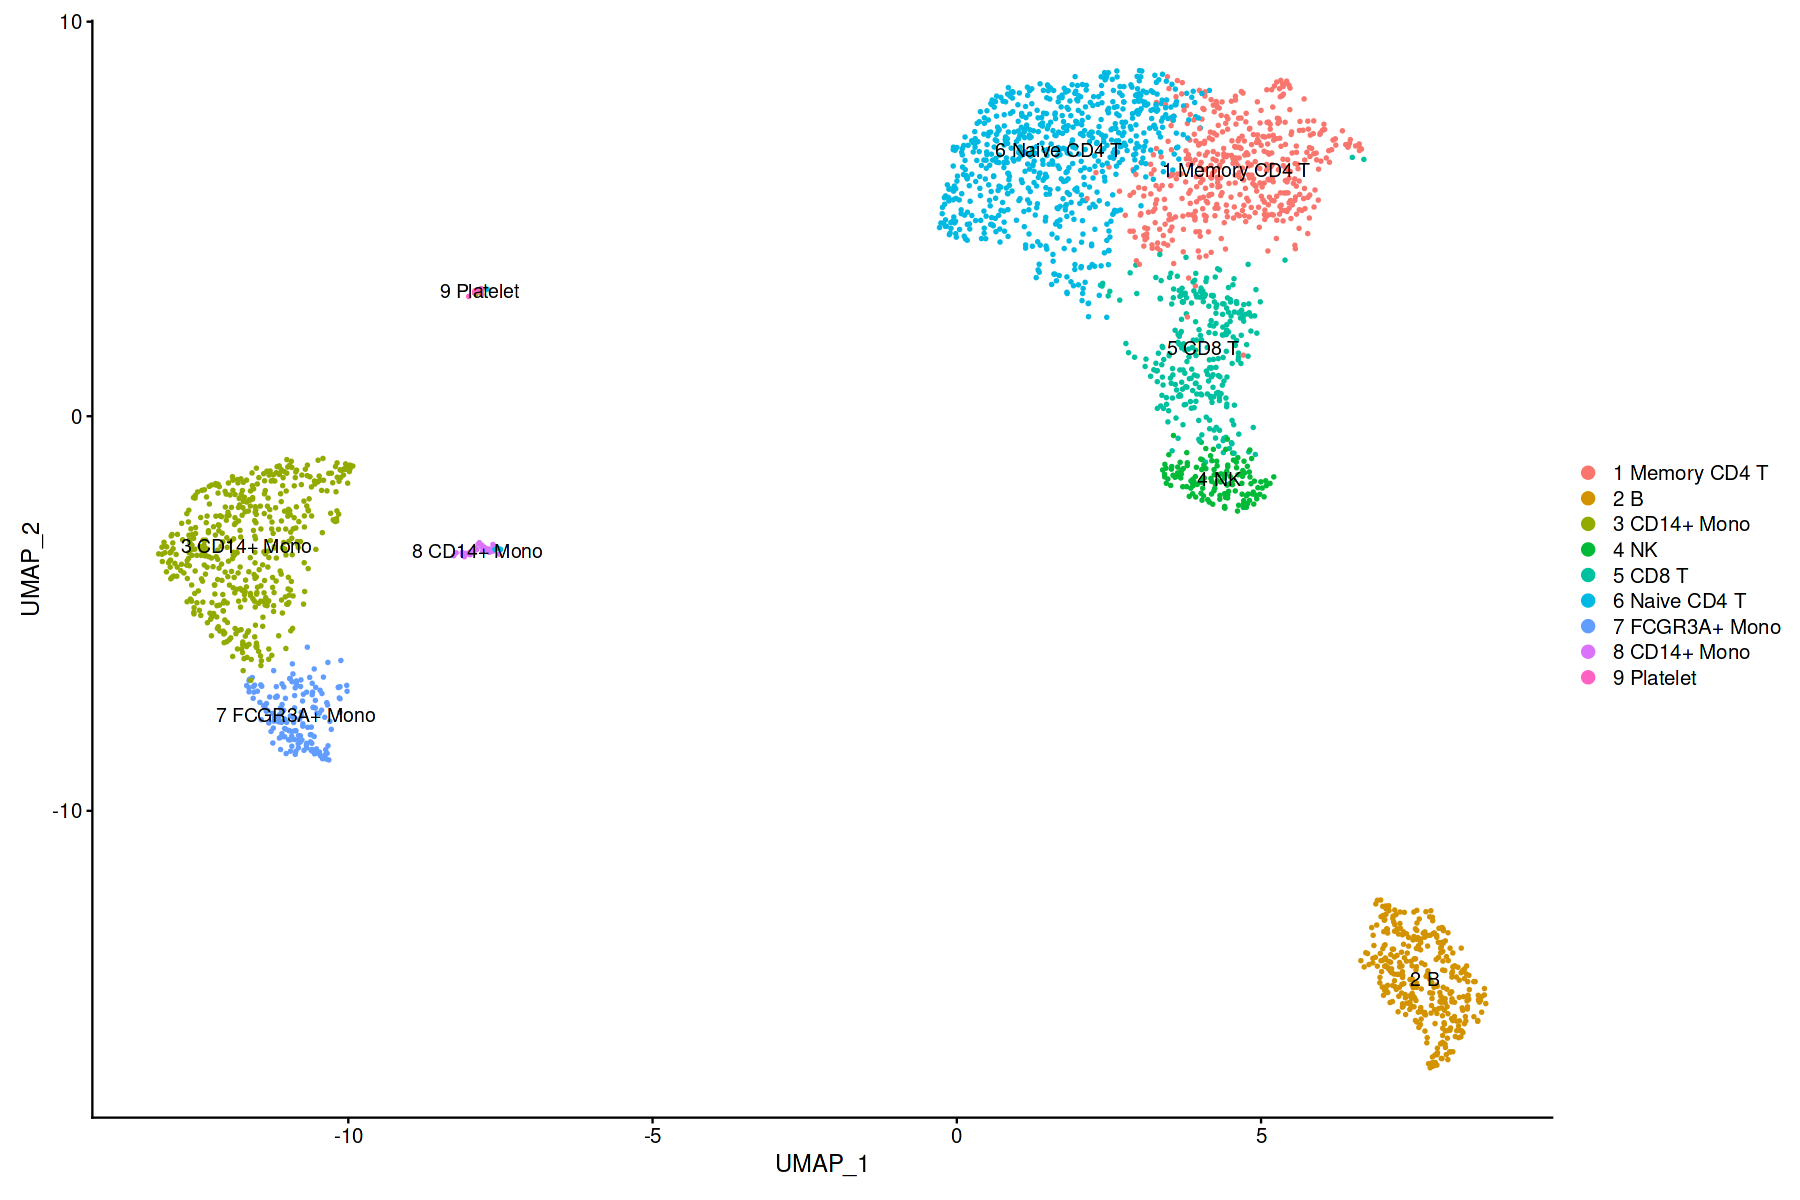

In [21]:
Idents(pbmc_min_change_attack) = "auto_annotation"
DimPlot(pbmc_min_change_attack, reduction = "umap", label = TRUE, pt.size = 0.5)

### The DotPlot shows that genes *FCER1A* and *CST3* are still markers of the cluster 8, suggesting a *DC* cluster to a human observer despite the SVMClassifier's classification of it as "CD14+ Mono".

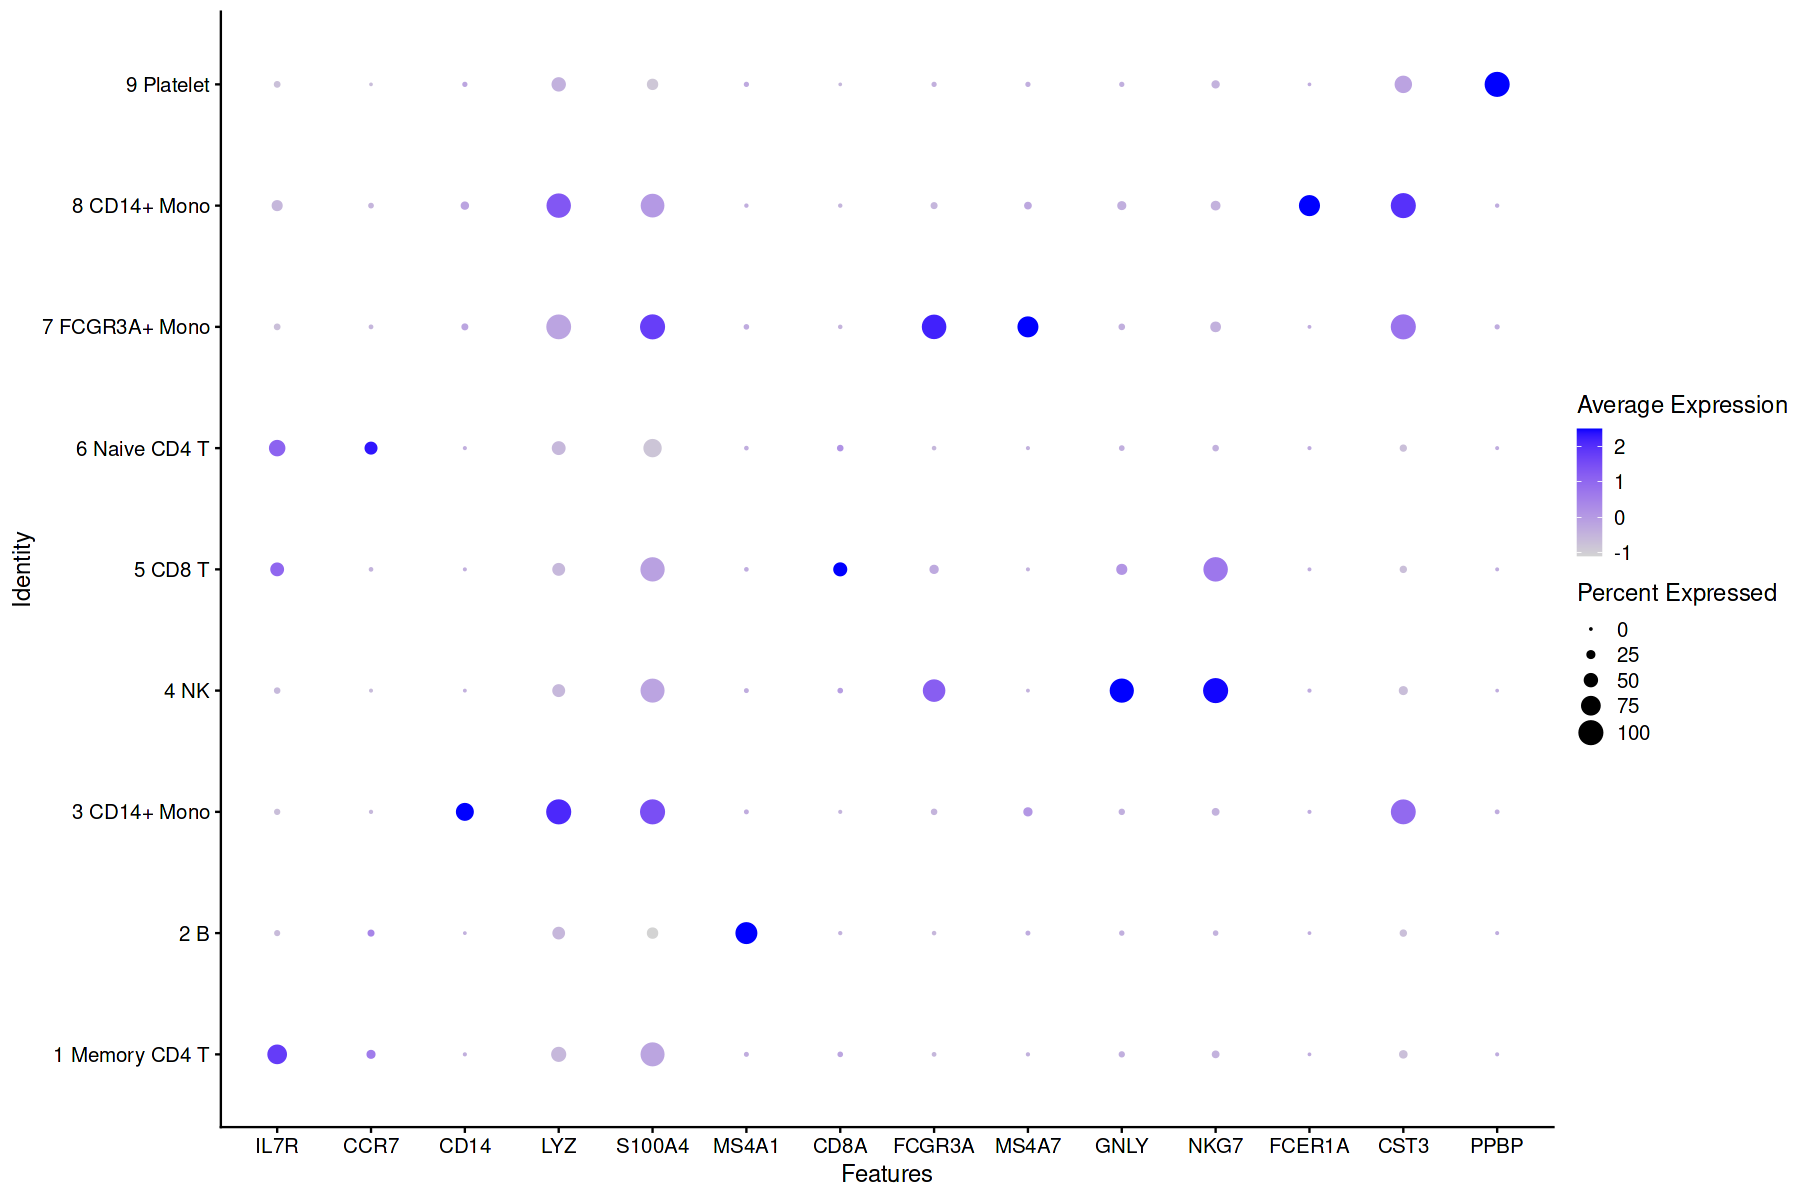

In [24]:
DotPlot(pbmc_min_change_attack, features=markers_4humans)

# Refine with <code>advGridMinChange</code>
The <code>advGridMinChange</code> function systematically evaluates all possible combinations of modifications on all possible combinations of a set of genes. However, this approach can be computationally intensive and is therefore only recommended for small sets of genes and modifications (i.e. $(modifications +1)^ {genes}< 500$) 

First we get the list of genes of the best solution generated by <code>advRandWalkMinChange</code>.

In [17]:
best_results = rand_walk_min_change_attacks[1,]
best_results = best_results[6:ncol(best_results)]
best_results

HLA-DQA2 HLA-DQA1 CLEC10A CPVL HLA-DMA LGALS2 HLA-DRB5 ALDH2 HLA-DMB SPI1 ⋯
192 NA       perc99   perc1   NA   NA      NA     NA       perc1 NA      NA   ⋯
    IL32 LGALS1 CD3E PTPRCAP C1orf162 S100A9 LCK CD7 GZMB RPS2
192 NA   NA     NA   NA      NA       NA     NA  NA  NA   NA

In [18]:
genes_4grid = colnames(best_results[,best_results!="NA"])
genes_4grid

[1] "HLA-DQA1" "CLEC10A"  "ALDH2"    "FCER1G"   "TYROBP"   "HLA-DRB1"
 [7] "HLA-DPA1" "HLA-DPB1" "HLA-DRA"  "CD74"

The <code>genes_4grid</code> contains a sufficiently small number of genes, we can refine the solution with the <code>advGridMinChange</code> function.

In [ ]:
grid_results = advGridMinChange(rna_matrix, clusters_id, "DC", SVMClassifier, genes_4grid, modifications)

Running combination: 1 on 59049



[1] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 2 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.8125"

Running combination: 3 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 4 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 5 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 6 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 7 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"   
[10] "perc1" "DC"    "0.875"

Running combination: 8 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 9 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 10 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 11 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 12 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 13 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 14 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 15 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 16 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 17 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc99"  "DC"      "0.96875"

Running combination: 18 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 19 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1"
[10] "perc1" "DC"    "0.75"

Running combination: 20 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 21 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 22 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 23 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 24 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 25 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 26 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 27 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 28 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 29 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 30 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 31 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 32 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 33 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 34 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 35 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 36 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 37 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 38 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 39 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 40 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 41 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 42 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 43 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 44 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 45 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 46 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 47 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 48 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 49 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 50 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 51 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 52 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 53 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 54 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 55 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "perc1"
[10] "perc1" "DC"    "0.5"

Running combination: 56 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 57 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 58 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 59 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 60 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 61 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 62 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 63 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 64 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 65 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 66 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 67 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 68 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 69 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 70 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 71 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 72 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 73 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 74 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 75 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 76 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 77 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 78 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 79 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 80 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 81 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 82 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 83 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 84 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 85 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 86 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 87 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 88 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 89 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 90 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 91 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 92 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 93 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 94 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 95 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 96 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 97 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 98 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 99 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 100 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 101 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 102 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 103 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 104 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 105 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 106 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 107 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 108 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 109 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 110 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 111 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 112 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 113 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 114 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 115 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 116 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 117 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 118 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 119 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 120 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 121 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 122 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 123 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 124 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 125 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 126 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 127 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 128 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 129 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 130 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 131 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 132 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 133 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 134 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 135 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 136 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 137 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 138 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 139 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 140 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 141 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 142 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 143 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 144 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 145 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 146 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 147 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 148 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 149 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 150 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 151 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 152 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 153 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 154 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 155 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 156 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 157 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 158 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 159 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 160 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 161 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 162 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 163 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 164 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 165 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 166 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 167 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 168 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 169 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 170 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 171 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 172 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 173 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 174 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 175 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 176 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 177 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 178 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 179 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 180 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 181 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 182 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 183 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 184 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 185 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 186 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 187 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 188 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 189 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 190 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 191 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 192 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 193 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 194 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 195 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 196 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 197 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 198 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 199 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 200 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 201 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 202 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 203 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 204 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 205 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 206 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 207 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 208 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 209 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 210 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 211 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 212 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 213 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 214 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 215 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 216 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 217 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 218 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 219 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 220 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 221 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 222 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 223 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 224 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 225 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 226 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 227 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 228 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 229 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 230 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 231 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 232 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 233 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 234 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 235 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 236 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 237 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 238 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 239 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 240 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 241 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 242 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 243 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 244 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 245 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 246 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 247 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 248 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 249 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 250 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 251 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 252 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 253 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 254 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 255 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 256 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 257 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 258 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 259 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 260 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 261 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 262 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 263 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 264 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 265 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 266 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 267 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 268 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 269 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 270 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 271 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 272 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 273 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 274 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 275 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 276 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 277 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 278 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 279 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 280 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 281 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 282 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 283 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 284 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 285 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 286 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 287 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 288 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 289 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 290 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 291 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 292 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 293 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 294 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 295 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 296 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 297 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 298 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 299 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 300 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 301 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 302 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 303 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 304 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 305 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 306 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 307 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 308 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 309 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 310 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 311 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 312 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 313 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 314 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 315 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 316 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 317 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 318 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 319 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 320 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 321 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 322 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 323 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 324 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 325 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 326 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 327 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 328 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 329 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 330 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 331 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 332 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 333 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 334 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 335 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 336 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 337 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 338 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 339 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 340 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 341 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 342 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 343 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 344 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 345 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 346 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 347 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 348 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 349 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 350 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 351 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 352 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 353 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 354 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 355 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 356 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 357 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 358 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 359 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 360 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 361 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 362 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 363 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 364 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 365 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 366 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 367 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 368 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 369 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 370 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 371 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 372 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 373 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 374 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 375 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 376 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 377 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 378 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 379 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 380 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 381 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 382 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 383 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 384 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 385 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 386 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 387 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 388 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 389 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 390 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 391 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 392 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 393 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 394 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 395 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 396 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 397 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 398 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 399 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 400 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 401 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 402 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 403 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 404 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 405 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 406 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 407 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 408 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 409 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 410 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 411 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 412 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 413 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 414 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 415 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 416 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 417 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 418 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 419 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 420 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 421 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 422 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 423 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 424 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 425 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 426 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 427 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 428 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 429 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 430 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 431 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 432 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 433 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 434 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 435 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 436 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 437 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 438 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 439 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 440 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 441 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 442 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 443 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 444 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 445 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 446 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 447 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 448 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 449 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 450 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 451 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 452 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 453 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 454 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 455 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 456 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 457 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 458 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 459 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 460 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 461 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 462 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 463 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 464 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 465 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 466 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 467 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 468 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 469 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 470 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 471 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 472 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 473 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 474 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 475 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 476 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 477 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 478 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 479 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 480 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 481 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 482 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 483 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 484 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 485 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 486 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 487 on 59049



[1] "perc1"      "perc1"      "perc1"      "perc1"      "NA"        
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 488 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 489 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 490 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 491 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 492 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 493 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1" "NA"   
[10] "perc1" "DC"    "0.875"

Running combination: 494 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 495 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 496 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 497 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 498 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 499 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 500 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 501 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 502 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 503 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 504 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 505 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 506 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 507 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 508 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 509 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 510 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 511 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 512 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 513 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 514 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 515 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 516 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 517 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 518 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 519 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 520 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 521 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 522 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 523 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 524 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 525 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 526 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 527 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 528 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 529 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 530 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 531 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 532 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 533 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 534 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 535 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 536 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 537 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 538 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 539 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 540 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 541 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "perc1"
[10] "perc1" "DC"    "0.5"

Running combination: 542 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 543 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 544 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 545 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 546 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 547 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 548 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 549 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 550 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 551 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 552 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 553 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 554 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 555 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 556 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 557 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 558 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 559 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 560 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 561 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 562 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 563 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 564 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 565 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 566 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 567 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 568 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 569 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 570 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 571 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 572 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 573 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 574 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 575 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 576 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 577 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 578 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 579 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 580 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 581 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 582 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 583 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 584 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 585 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 586 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 587 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 588 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 589 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 590 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 591 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 592 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 593 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 594 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 595 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 596 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 597 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 598 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 599 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 600 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 601 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 602 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 603 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 604 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 605 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 606 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 607 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 608 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 609 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 610 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 611 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 612 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 613 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 614 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 615 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 616 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 617 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 618 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 619 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 620 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 621 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 622 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 623 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 624 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 625 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 626 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 627 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 628 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 629 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 630 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 631 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 632 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 633 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 634 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 635 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 636 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 637 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 638 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 639 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 640 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 641 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 642 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 643 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 644 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 645 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 646 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 647 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 648 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 649 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 650 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 651 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 652 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 653 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 654 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 655 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 656 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 657 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 658 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 659 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 660 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 661 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 662 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 663 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 664 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 665 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 666 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 667 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 668 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 669 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 670 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 671 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 672 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 673 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 674 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 675 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 676 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 677 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 678 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 679 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 680 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 681 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 682 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 683 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 684 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 685 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 686 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 687 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 688 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 689 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 690 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 691 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 692 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 693 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 694 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 695 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 696 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 697 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 698 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 699 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 700 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 701 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 702 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 703 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "perc1"
[10] "perc1" "DC"    "0.75"

Running combination: 704 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 705 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 706 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 707 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 708 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 709 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 710 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 711 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 712 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 713 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 714 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 715 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 716 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 717 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 718 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 719 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 720 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 721 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 722 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 723 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 724 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 725 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 726 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 727 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 728 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 729 on 59049



[1] "perc1" "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 730 on 59049



[1] "perc1"      "perc1"      "perc1"      "perc99"     "perc1"     
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 731 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.78125"

Running combination: 732 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 733 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 734 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 735 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 736 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 737 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 738 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 739 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 740 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 741 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 742 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 743 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 744 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 745 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 746 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc99"  "DC"      "0.96875"

Running combination: 747 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 748 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 749 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 750 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 751 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 752 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 753 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 754 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 755 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 756 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 757 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 758 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.8125"

Running combination: 759 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 760 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 761 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 762 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 763 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 764 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 765 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 766 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 767 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 768 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 769 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 770 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 771 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 772 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 773 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 774 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 775 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 776 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 777 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 778 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 779 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 780 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 781 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 782 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 783 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 784 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 785 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 786 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 787 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 788 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 789 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 790 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 791 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 792 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 793 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 794 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 795 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 796 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 797 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 798 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 799 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 800 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 801 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 802 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 803 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 804 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 805 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 806 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 807 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 808 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 809 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 810 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 811 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 812 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 813 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 814 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 815 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 816 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 817 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 818 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 819 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 820 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 821 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 822 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 823 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 824 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 825 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 826 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 827 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 828 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 829 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 830 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 831 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 832 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 833 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 834 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 835 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 836 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 837 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 838 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 839 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 840 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 841 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 842 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 843 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 844 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 845 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 846 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 847 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 848 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 849 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 850 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 851 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 852 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 853 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 854 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 855 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 856 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 857 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 858 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 859 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 860 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 861 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 862 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 863 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 864 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 865 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 866 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 867 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 868 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 869 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 870 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 871 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 872 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 873 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 874 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 875 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 876 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 877 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 878 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 879 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 880 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 881 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 882 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 883 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 884 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 885 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 886 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 887 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 888 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 889 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 890 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 891 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 892 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 893 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 894 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 895 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 896 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 897 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 898 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 899 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 900 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 901 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 902 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 903 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 904 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 905 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 906 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 907 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 908 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 909 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 910 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 911 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 912 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 913 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 914 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 915 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 916 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 917 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 918 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 919 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 920 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 921 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 922 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 923 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 924 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 925 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 926 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 927 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 928 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 929 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 930 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 931 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 932 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 933 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 934 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 935 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 936 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 937 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 938 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 939 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 940 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 941 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 942 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 943 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 944 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 945 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 946 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 947 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 948 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 949 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 950 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 951 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 952 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 953 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 954 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 955 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 956 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 957 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 958 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 959 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 960 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 961 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 962 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 963 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 964 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 965 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 966 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 967 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 968 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 969 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 970 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc1"   "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 971 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 972 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 973 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 974 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 975 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 976 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 977 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 978 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 979 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 980 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 981 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 982 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 983 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 984 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 985 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 986 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 987 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 988 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 989 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 990 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 991 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 992 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 993 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 994 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 995 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 996 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 997 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 998 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 999 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1000 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 1001 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1002 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1003 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1004 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1005 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1006 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1007 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1008 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1009 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1010 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1011 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1012 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1013 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1014 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1015 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1016 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1017 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1018 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1019 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1020 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1021 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1022 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1023 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1024 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1025 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1026 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1027 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 1028 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1029 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1030 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1031 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1032 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1033 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1034 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1035 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1036 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1037 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1038 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1039 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1040 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1041 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1042 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1043 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1044 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1045 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1046 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1047 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1048 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1049 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1050 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1051 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc1"   "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1052 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1053 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1054 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1055 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1056 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1057 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1058 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1059 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1060 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1061 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1062 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1063 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1064 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1065 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1066 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1067 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1068 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1069 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1070 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1071 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1072 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1073 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1074 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1075 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1076 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1077 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1078 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1079 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1080 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1081 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1082 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1083 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1084 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1085 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1086 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1087 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1088 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1089 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1090 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1091 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1092 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1093 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1094 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1095 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1096 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1097 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1098 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1099 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1100 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1101 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1102 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1103 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1104 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1105 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1106 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1107 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1108 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1109 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1110 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1111 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1112 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1113 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1114 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1115 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1116 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1117 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1118 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1119 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1120 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1121 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1122 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1123 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1124 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1125 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1126 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1127 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1128 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1129 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1130 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1131 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1132 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1133 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1134 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1135 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 1136 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1137 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1138 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1139 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1140 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1141 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1142 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1143 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1144 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1145 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1146 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1147 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1148 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1149 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1150 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1151 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1152 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1153 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1154 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1155 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1156 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1157 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1158 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1159 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1160 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1161 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1162 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 1163 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1164 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1165 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1166 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1167 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1168 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1169 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1170 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1171 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1172 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1173 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1174 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1175 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1176 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1177 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1178 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1179 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1180 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1181 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1182 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1183 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1184 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1185 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1186 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1187 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1188 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1189 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1190 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1191 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1192 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1193 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1194 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1195 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1196 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1197 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1198 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1199 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1200 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1201 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1202 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1203 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1204 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1205 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1206 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1207 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1208 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1209 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1210 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1211 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1212 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1213 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "perc99"  "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1214 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1215 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1216 on 59049



[1] "perc1"      "perc1"      "perc1"      "perc99"     "NA"        
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 1217 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.8125"

Running combination: 1218 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 1219 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1220 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1221 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1222 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1223 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1224 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1225 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1226 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1227 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1228 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1229 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1230 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1231 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1232 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1233 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1234 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1235 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1236 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1237 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1238 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1239 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1240 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1241 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1242 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1243 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 1244 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1245 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1246 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1247 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1248 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1249 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1250 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1251 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1252 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1253 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1254 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1255 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1256 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1257 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1258 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1259 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1260 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1261 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1262 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1263 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1264 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1265 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1266 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1267 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1268 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1269 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1270 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 1271 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1272 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1273 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1274 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1275 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1276 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1277 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1278 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1279 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1280 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1281 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1282 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1283 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1284 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1285 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1286 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1287 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1288 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1289 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1290 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1291 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1292 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1293 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1294 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc1"   "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1295 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1296 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1297 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 1298 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1299 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1300 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1301 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1302 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1303 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1304 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1305 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1306 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1307 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1308 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1309 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1310 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1311 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1312 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1313 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1314 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1315 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1316 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1317 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1318 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1319 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1320 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1321 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1322 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1323 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1324 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 1325 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1326 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1327 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1328 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1329 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1330 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1331 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1332 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1333 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1334 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1335 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1336 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1337 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1338 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1339 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1340 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1341 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1342 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1343 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1344 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1345 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1346 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1347 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1348 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1349 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1350 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1351 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1352 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1353 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1354 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1355 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1356 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1357 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1358 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1359 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1360 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1361 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1362 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1363 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1364 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1365 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1366 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1367 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1368 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1369 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1370 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1371 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1372 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1373 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1374 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1375 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1376 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1377 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1378 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 1379 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1380 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1381 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1382 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1383 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1384 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1385 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1386 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1387 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1388 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1389 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1390 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1391 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1392 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1393 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1394 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1395 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1396 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1397 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1398 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1399 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1400 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1401 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1402 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1403 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1404 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1405 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1406 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1407 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1408 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1409 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1410 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1411 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1412 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1413 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1414 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1415 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1416 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1417 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1418 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1419 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1420 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1421 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1422 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1423 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1424 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1425 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1426 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1427 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1428 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1429 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1430 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1431 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1432 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1433 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1434 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1435 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1436 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1437 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1438 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1439 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1440 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1441 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1442 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1443 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1444 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1445 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1446 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1447 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1448 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1449 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1450 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1451 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1452 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1453 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1454 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1455 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1456 on 59049



[1] "perc1"   "perc1"   "perc1"   "perc99"  "NA"      "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1457 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1458 on 59049



[1] "perc1"  "perc1"  "perc1"  "perc99" "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1459 on 59049



[1] "perc1"      "perc1"      "perc1"      "NA"         "perc1"     
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 1460 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.8125"

Running combination: 1461 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 1462 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1463 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1464 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1465 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1" "perc1" "NA"   
[10] "perc1" "DC"    "0.875"

Running combination: 1466 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1467 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1468 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 1469 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1470 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1471 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1472 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1473 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1474 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1475 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1476 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1477 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1" "NA"    "perc1"
[10] "perc1" "DC"    "0.75"

Running combination: 1478 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1479 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1480 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1481 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1482 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1483 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1484 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1485 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1486 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 1487 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1488 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 1489 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1490 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1491 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1492 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1493 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1494 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1495 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1496 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1497 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1498 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1499 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1500 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1501 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1502 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1503 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1504 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1505 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1506 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1507 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1508 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1509 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1510 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1511 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1512 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1513 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "NA"    "perc1" "perc1"
[10] "perc1" "DC"    "0.5"

Running combination: 1514 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1515 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 1516 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1517 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1518 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1519 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "NA"    "perc1" "NA"   
[10] "perc1" "DC"    "0.875"

Running combination: 1520 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1521 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1522 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1523 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1524 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1525 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1526 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1527 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1528 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1529 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1530 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1531 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1532 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1533 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1534 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1535 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1536 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1537 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1538 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1539 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "perc1" "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1540 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 1541 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1542 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1543 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1544 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1545 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1546 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1547 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1548 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1549 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1550 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1551 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1552 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1553 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1554 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1555 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1556 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1557 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1558 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1559 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1560 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1561 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1562 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1563 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1564 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1565 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1566 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1567 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 1568 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1569 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1570 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1571 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1572 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1573 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1574 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1575 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1576 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1577 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1578 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1579 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1580 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1581 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1582 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1583 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1584 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1585 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1586 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1587 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1588 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1589 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1590 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1591 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1592 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1593 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1594 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 1595 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1596 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1597 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1598 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1599 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1600 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1601 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1602 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1603 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1604 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1605 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1606 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1607 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1608 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1609 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1610 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1611 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1612 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1613 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1614 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1615 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1616 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1617 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1618 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1619 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1620 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1621 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 1622 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1623 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 1624 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1625 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1626 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1627 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1628 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1629 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1630 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1631 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1632 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1633 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1634 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1635 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1636 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1637 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1638 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1639 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1640 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1641 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 1642 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1643 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1644 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1645 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1646 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1647 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1648 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1649 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1650 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1651 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1652 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1653 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1654 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1655 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1656 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1657 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1658 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1659 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1660 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1661 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1662 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1663 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1664 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1665 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1666 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1667 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1668 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1669 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1670 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1671 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1672 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1673 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1674 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1675 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 1676 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1677 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "NA"    "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 1678 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1679 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1680 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1681 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1682 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1683 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1684 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1685 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1686 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1687 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1688 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1689 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1690 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1691 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1692 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1693 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1694 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1695 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "NA"    "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 1696 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc1"   "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1697 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1698 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1699 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1700 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1701 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "perc1" "NA"    "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1702 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 1703 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1704 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1705 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1706 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1707 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1708 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1709 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1710 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1711 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1712 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1713 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1714 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1715 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1716 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1717 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1718 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1719 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1720 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1721 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1722 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1723 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1724 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1725 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1726 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1727 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1728 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1729 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 1730 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1731 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1732 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1733 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1734 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1735 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1736 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1737 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1738 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1739 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1740 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1741 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1742 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1743 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1744 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1745 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1746 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1747 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1748 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1749 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1750 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1751 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1752 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1753 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1754 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1755 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1756 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 1757 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 1758 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1759 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1760 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1761 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1762 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 1763 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1764 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1765 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1766 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1767 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1768 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1769 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1770 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1771 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1772 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1773 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1774 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1775 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1776 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1777 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1778 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1779 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1780 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc1"   "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1781 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1782 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1783 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1784 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1785 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1786 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1787 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1788 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1789 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1790 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1791 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1792 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1793 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1794 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1795 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1796 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1797 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1798 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1799 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1800 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1801 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1802 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1803 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1804 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1805 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1806 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1807 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1808 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1809 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1810 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1811 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1812 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1813 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1814 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1815 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1816 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1817 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1818 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1819 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1820 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1821 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1822 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1823 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1824 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1825 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1826 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1827 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1828 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1829 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1830 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1831 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1832 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1833 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1834 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1835 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1836 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1837 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1838 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1839 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1840 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1841 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1842 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1843 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1844 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1845 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1846 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1847 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1848 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1849 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1850 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1851 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1852 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1853 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1854 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1855 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1856 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1857 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1858 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1859 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1860 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1861 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1862 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1863 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1864 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 1865 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 1866 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1867 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1868 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1869 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1870 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1871 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1872 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1873 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1874 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1875 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1876 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1877 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1878 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1879 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1880 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1881 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1882 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1883 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1884 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1885 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1886 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1887 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1888 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1889 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1890 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1891 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 1892 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1893 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1894 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1895 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1896 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1897 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1898 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1899 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1900 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1901 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1902 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1903 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1904 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1905 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1906 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1907 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1908 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1909 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1910 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1911 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1912 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1913 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1914 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1915 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1916 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1917 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1918 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 1919 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1920 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 1921 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 1922 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1923 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1924 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1925 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1926 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1927 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 1928 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1929 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 1930 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1931 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1932 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1933 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1934 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1935 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1936 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1937 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 1938 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 1939 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1940 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 1941 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1942 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "perc99"  "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1943 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1944 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "perc99" "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1945 on 59049



[1] "perc1"      "perc1"      "perc1"      "NA"         "NA"        
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 1946 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.8125"

Running combination: 1947 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 1948 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1949 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1950 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1951 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "perc1" "perc1" "NA"   
[10] "perc1" "DC"    "0.875"

Running combination: 1952 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1953 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1954 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 1955 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1956 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1957 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1958 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1959 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1960 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1961 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1962 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1963 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 1964 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1965 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1966 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1967 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1968 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1969 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 1970 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1971 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 1972 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 1973 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 1974 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 1975 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1976 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1977 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 1978 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 1979 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 1980 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1981 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 1982 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1983 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1984 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 1985 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1986 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1987 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1988 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1989 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1990 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 1991 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 1992 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 1993 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 1994 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 1995 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 1996 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 1997 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 1998 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 1999 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "perc1" "perc1"
[10] "perc1" "DC"    "0.5"

Running combination: 2000 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 2001 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 2002 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2003 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2004 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2005 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "perc1" "NA"   
[10] "perc1" "DC"    "0.875"

Running combination: 2006 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2007 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 2008 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2009 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2010 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2011 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2012 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2013 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2014 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2015 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2016 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2017 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2018 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2019 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2020 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2021 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2022 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2023 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2024 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2025 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "perc1" "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 2026 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 2027 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 2028 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2029 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2030 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2031 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2032 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 2033 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2034 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2035 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2036 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2037 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2038 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2039 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2040 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2041 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2042 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2043 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2044 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2045 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2046 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2047 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2048 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2049 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2050 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2051 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2052 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2053 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 2054 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2055 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2056 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2057 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2058 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2059 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2060 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2061 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2062 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2063 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2064 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2065 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2066 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2067 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2068 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2069 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2070 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2071 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2072 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2073 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2074 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2075 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2076 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2077 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2078 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2079 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2080 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 2081 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2082 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2083 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2084 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2085 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2086 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2087 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2088 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2089 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2090 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2091 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2092 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2093 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2094 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2095 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2096 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2097 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2098 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2099 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2100 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2101 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2102 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2103 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2104 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2105 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2106 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2107 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 2108 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2109 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 2110 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2111 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2112 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2113 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 2114 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2115 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 2116 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2117 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2118 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2119 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2120 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2121 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2122 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2123 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2124 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2125 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2126 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2127 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 2128 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2129 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2130 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2131 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2132 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2133 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "perc1" "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 2134 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 2135 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2136 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2137 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2138 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2139 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2140 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2141 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2142 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2143 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2144 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2145 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2146 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2147 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2148 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2149 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2150 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2151 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2152 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2153 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2154 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2155 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2156 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 2157 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2158 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2159 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2160 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2161 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 2162 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2163 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"    "perc1" "perc1"
[10] "NA"    "DC"    "0.875"

Running combination: 2164 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2165 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2166 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2167 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2168 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2169 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"    "perc1" "NA"   
[10] "NA"    "DC"    "1"

Running combination: 2170 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2171 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2172 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2173 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2174 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2175 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2176 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2177 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2178 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2179 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2180 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2181 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"    "NA"    "perc1"
[10] "NA"    "DC"    "1"

Running combination: 2182 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2183 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 2184 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2185 on 59049



[1] "perc1"   "perc1"   "perc1"   "NA"      "NA"      "NA"      "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2186 on 59049



[1] "perc1"  "perc1"  "perc1"  "NA"     "NA"     "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2187 on 59049



[1] "perc1" "perc1" "perc1" "NA"    "NA"    "NA"    "NA"    "NA"    "NA"   
[10] "NA"    "DC"    "1"

Running combination: 2188 on 59049



[1] "perc1"      "perc1"      "perc99"     "perc1"      "perc1"     
 [6] "perc1"      "perc1"      "perc1"      "perc1"      "perc1"     
[11] "CD14+ Mono" "0.4375"

Running combination: 2189 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 2190 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.84375"

Running combination: 2191 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2192 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2193 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 2194 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 2195 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2196 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2197 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 2198 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2199 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2200 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2201 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2202 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2203 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2204 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2205 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2206 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2207 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2208 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2209 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2210 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2211 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2212 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2213 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2214 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2215 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 2216 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 2217 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2218 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2219 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2220 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 2221 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 2222 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2223 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2224 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2225 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2226 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2227 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2228 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2229 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2230 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2231 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2232 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2233 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2234 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2235 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2236 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2237 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2238 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2239 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2240 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2241 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2242 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5"

Running combination: 2243 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 2244 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2245 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2246 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2247 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 2248 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 2249 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2250 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2251 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2252 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2253 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2254 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2255 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2256 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2257 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2258 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2259 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2260 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2261 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2262 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2263 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2264 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2265 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2266 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2267 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2268 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2269 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 2270 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 2271 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2272 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2273 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2274 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2275 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.875"

Running combination: 2276 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2277 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2278 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2279 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2280 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2281 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2282 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2283 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2284 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2285 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2286 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2287 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2288 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2289 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2290 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2291 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2292 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2293 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2294 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2295 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2296 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.625"

Running combination: 2297 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2298 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2299 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2300 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2301 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2302 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2303 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2304 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2305 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2306 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2307 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2308 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2309 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2310 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2311 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2312 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2313 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2314 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2315 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2316 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2317 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2318 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2319 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2320 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2321 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2322 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2323 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.65625"

Running combination: 2324 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2325 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2326 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2327 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2328 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2329 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2330 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2331 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2332 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 2333 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2334 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2335 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2336 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2337 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2338 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2339 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2340 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2341 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2342 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2343 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2344 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2345 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2346 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2347 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2348 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2349 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2350 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.59375"

Running combination: 2351 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2352 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2353 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2354 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2355 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2356 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2357 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2358 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2359 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2360 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2361 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2362 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2363 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2364 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2365 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2366 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2367 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2368 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2369 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2370 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2371 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2372 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2373 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2374 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2375 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2376 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2377 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 2378 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2379 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2380 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2381 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2382 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2383 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2384 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2385 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2386 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 2387 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2388 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2389 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2390 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2391 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2392 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2393 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2394 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2395 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2396 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2397 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2398 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2399 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 2400 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2401 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2402 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2403 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2404 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2405 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.90625"

Running combination: 2406 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2407 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2408 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2409 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2410 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2411 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2412 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2413 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 2414 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2415 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2416 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2417 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2418 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2419 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2420 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2421 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2422 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2423 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2424 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2425 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc1"   "NA"      "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2426 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "perc99" "DC"     "1"

Running combination: 2427 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2428 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc1"  "DC"     "1"

Running combination: 2429 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2430 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc1"  "NA"     "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2431 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.53125"

Running combination: 2432 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc1"   "perc99"  "DC"      "0.84375"

Running combination: 2433 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2434 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2435 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2436 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "perc99"  "NA"      "DC"      "0.96875"

Running combination: 2437 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 2438 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2439 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2440 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2441 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2442 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2443 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2444 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2445 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2446 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2447 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2448 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2449 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2450 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2451 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2452 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2453 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2454 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2455 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2456 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2457 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2458 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 2459 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 2460 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2461 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2462 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2463 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2464 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.90625"

Running combination: 2465 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc1"   "NA"      "perc99"  "DC"      "0.96875"

Running combination: 2466 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2467 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2468 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2469 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2470 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2471 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2472 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2473 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2474 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2475 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2476 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2477 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2478 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2479 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2480 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2481 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2482 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2483 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2484 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2485 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.5625"

Running combination: 2486 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.875"

Running combination: 2487 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc1"  "NA"     "DC"     "0.875"

Running combination: 2488 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2489 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2490 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2491 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2492 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2493 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2494 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2495 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2496 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2497 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2498 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2499 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2500 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2501 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2502 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2503 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.78125"

Running combination: 2504 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2505 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2506 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2507 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2508 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2509 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc1"   "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2510 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2511 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc1"  "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2512 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 2513 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2514 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2515 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2516 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2517 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2518 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc1"  "DC"     "0.9375"

Running combination: 2519 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2520 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2521 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2522 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2523 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc1"  "NA"     "DC"     "0.9375"

Running combination: 2524 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2525 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2526 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2527 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2528 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2529 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2530 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2531 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2532 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2533 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2534 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2535 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2536 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc1"  
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2537 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2538 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc1"  "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2539 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.75"

Running combination: 2540 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2541 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2542 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc1"   "DC"      "0.90625"

Running combination: 2543 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2544 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2545 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2546 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2547 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2548 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2549 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2550 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2551 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2552 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2553 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2554 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2555 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2556 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2557 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "perc1"  "DC"     "0.875"

Running combination: 2558 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2559 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2560 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2561 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2562 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2563 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "perc99" 
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2564 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2565 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "perc99" "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2566 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "perc1"   "DC"      "0.71875"

Running combination: 2567 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2568 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2569 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2570 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2571 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2572 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2573 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2574 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2575 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 2576 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2577 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2578 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2579 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2580 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2581 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2582 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2583 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2584 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc1"   "DC"      "0.84375"

Running combination: 2585 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2586 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "perc1"  "NA"     "DC"     "1"

Running combination: 2587 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc1"   "DC"      "0.96875"

Running combination: 2588 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2589 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2590 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "perc99"  "NA"     
 [8] "NA"      "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2591 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2592 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "perc99" "NA"     "NA"    
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2593 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc1"  "DC"     "0.6875"

Running combination: 2594 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc1"  "perc99" "DC"     "0.9375"

Running combination: 2595 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc1"   "NA"      "DC"      "0.90625"

Running combination: 2596 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2597 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc1"   "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2598 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2599 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc1"   "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2600 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2601 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc1" 
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2602 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "perc1"  "perc1"  "DC"     "0.8125"

Running combination: 2603 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "perc99"  "DC"      "0.96875"

Running combination: 2604 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc1"   "NA"      "DC"      "0.96875"

Running combination: 2605 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "perc1"  "DC"     "0.9375"

Running combination: 2606 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "perc99"  "perc99"  "DC"      "0.96875"

Running combination: 2607 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "perc99" "NA"     "DC"     "1"

Running combination: 2608 on 59049



[1] "perc1"   "perc1"   "perc99"  "perc1"   "perc99"  "NA"      "perc1"  
 [8] "perc99"  "NA"      "perc1"   "DC"      "0.96875"

Running combination: 2609 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "perc99" "DC"     "1"

Running combination: 2610 on 59049



[1] "perc1"  "perc1"  "perc99" "perc1"  "perc99" "NA"     "perc1"  "perc99"
 [9] "NA"     "NA"     "DC"     "1"

Running combination: 2611 on 59049



In [ ]:
save.image("session/006_20230124_full3")

In [ ]:
head(grid_results)